In [1]:
import h5py, os, pickle
from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from ecog.utils import bands
from cv_paper_plots.style import subject_colors, letter_fontstyle, ticklabel_fontstyle
from cv_paper_plots import xfreq_analysis, xfreq_classification

import scipy as sp
from cv_paper_plots.xfreq_analysis import good_examples_and_channels

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder = os.path.join(os.environ['HOME'],'Development/data/ecog/AA_ff/')
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP31_blocks_1_2_4_6_9_21_63_65_67_69_71_78_82_83_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP33_blocks_1_5_30_CV_AA_ff_align_window_-0.5_to_0.79_none.h5']
freqs = bands.chang_lab['cfs']

In [3]:
subject_idx = 0
subject = subjects[subject_idx]

In [4]:
baselines = dict()
with h5py.File(os.path.join(folder, files[subject_idx])) as f:
    block_labels = f['block'].value
    for key, value in f.items():
        if ('block' in key) and ('band' in key):
            items = key.split('_')
            block, band = int(items[2]), int(items[4])
            baselines[(block, band)] = np.squeeze(value.value).astype('float32')
    good_examples, good_channels = good_examples_and_channels(f['X0'].value)
    vsmc = np.concatenate([f['anatomy']['preCG'].value, f['anatomy']['postCG'].value])
    vsmc_electrodes = np.zeros(256)
    vsmc_electrodes[vsmc] = 1

    good_examples = sorted(np.nonzero(good_examples)[0].tolist())

    good_channels = sorted(np.nonzero(vsmc_electrodes * good_channels)[0].tolist())
    n_trials, n_channels, n_time = f['X0'].shape
    print(len(good_examples), len(good_channels))
    X = np.zeros((40, len(good_examples), len(good_channels), n_time), dtype='float32')
    block_labels = block_labels[good_examples]
    for ii in range(40):
        X[ii] = f['X{}'.format(ii)][good_examples][:, good_channels]
    labels = f['y'][good_examples]

def new_ch_idx(old_idx):
    return (np.array(good_channels) == old_idx).argmax()

2572 85


In [5]:
blocks = sorted(set(block_labels))
bl_mean = np.zeros((len(blocks), 40, len(good_channels)))
bl_std = np.zeros((len(blocks), 40, len(good_channels)))
for ii, block in enumerate(blocks):
    for band in range(40):
        data = baselines[(block, band)][good_channels]
        bl_mean[ii, band] = data.mean(axis=-1)
        bl_std[ii, band] = data.std(axis=-1)

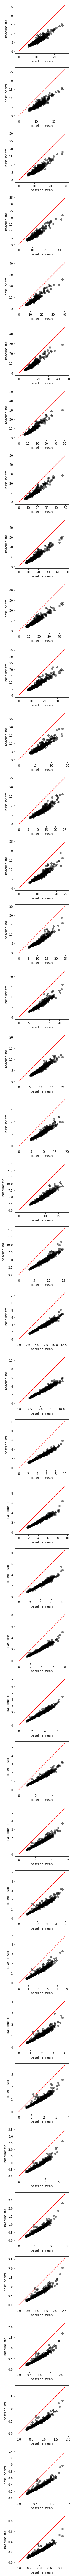

In [6]:
f, axes = plt.subplots(40, figsize=(3.5, 120))
for ii, ax in enumerate(axes):
    x = bl_mean[:, ii].ravel()
    y = bl_std[:, ii].ravel()
    ax.scatter(x, y, c='k', alpha=.5)
    size = 1.05 * max(x.max(), y.max())
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xlabel('baseline mean')
    ax.set_ylabel('baseline std')
    ax.axis('equal')
    ax.plot([0, size], [0, size], c='r')
f.tight_layout()

# Forward / Invert

In [7]:
def forward_bl(X, bl_type):
    means = np.full((X.shape[0], len(blocks), X.shape[2], 1), np.nan)
    for ii, block in enumerate(blocks):
        idxs = block_labels == block
        if bl_type == 'bl_mean':
            X[:, idxs] /= bl_mean[ii, :, np.newaxis, :, np.newaxis]
        elif bl_type == 'data_mean':
            means[:, [ii]] = X[:, idxs].mean(axis=(1, 3), keepdims=True)
            X[:, idxs] /= means[:, [ii]]
        else:
            raise ValueError
    return X, means

def invert_bl(X, bl_type, means):
    for ii, block in enumerate(blocks):
        idxs = block_labels == block
        if bl_type == 'bl_mean':
            X[:, idxs] *= bl_mean[ii, :, np.newaxis, :, np.newaxis]
        elif bl_type == 'data_mean':
            X[:, idxs] *= means[:, [ii]]
        else:
            raise ValueError
    return X

# Power spectra

KeyboardInterrupt: 

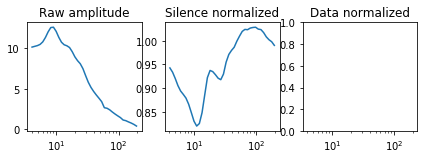

In [51]:
f, axes = plt.subplots(1, 3, figsize=(7, 2), sharex=True)
titles = ['Raw amplitude', 'Silence normalized', 'Data normalized']
for ii, bl_type in enumerate([None, 'bl_mean', 'data_mean']):
    axes[ii].set_title(titles[ii])
    if bl_type is not None:
        X, bl_type_mean = forward_bl(X, bl_type)
    axes[ii].plot(bands.chang_lab['cfs'], X.mean(axis=(1, 2, 3)))
    if bl_type is not None:
        X = invert_bl(X, bl_type, bl_type_mean)
    axes[ii].set_xscale('log')
axes[0].set_ylabel('Amplitude')
for ax in axes:
    ax.set_xlabel('Center frequency (Hz)')
    
for ax in axes[1:]:
    ax.set_ylim(0, 1.1)
    ax.set_yticks([0, 1])
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_power_spectra.pdf'.subject))

# PCA

In [9]:
rng = np.random.RandomState(20180917)

pcs = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs = np.full((2, 2, 2, len(good_channels), 3), np.nan)

means = np.full((2, 2, 2, len(good_channels), 40), np.nan)

pcs_s = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, 2, 2, len(good_channels), 3), np.nan)

def get_pcs(d, center_pca):
    mean = d.mean(axis=0)
    if center_pca:
        d = (d - mean) / np.sqrt(d.shape[0])
    return sp.linalg.eigh(d.T.dot(d), eigvals=(39-2, 39)), mean

for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    X, bl_type_means = forward_bl(X, bl_type)
    for ch in range(len(good_channels)):
        d = X[:, :, ch].reshape(40, -1).T
        for jj, center_pca in enumerate([True, False]):
            for kk, log in enumerate([True, False]):
                if log:
                    dp = np.log(d)
                else:
                    dp = d
                dp_s = np.zeros_like(dp)
                for nn in range(dp.shape[1]):
                    dp_s[:, nn] = rng.permutation(dp[:, nn])
                (w, v), m = get_pcs(dp, center_pca)
                pcs[ii, jj, kk, ch] = v[:, ::-1].T
                evs[ii, jj, kk, ch] = w[::-1]
                means[ii, jj, kk, ch] = m
                (w_s, v_s), _ = get_pcs(dp_s, center_pca)
                pcs_s[ii, jj, kk, ch] = v_s[:, ::-1].T
                evs_s[ii, jj, kk, ch] = w_s[::-1]
    X = invert_bl(X, bl_type, bl_type_means)
def flip(pcs):
    fl = 2 * (abs(pcs.max(axis=-1, keepdims=True)) >= abs(pcs.min(axis=-1, keepdims=True))) -1
    return fl * pcs
pcs = flip(pcs)
pcs_s = flip(pcs_s)

KeyboardInterrupt: 

In [ ]:
np.savez('{}_pca_analysis'.format(subject), pcs=pcs, evs=evs, axes=['bl_type',
                                                                    'center_pca',
                                                                    'log'])

In [ ]:
def plot_PC0s(pcs, evs, mean, faxes, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(2.5, 12))
    f, (ax0, ax1) = faxes
    ratios = evs[:, 1:]/evs[:, [0]]
    ax0.plot(np.tile(freqs[np.newaxis], (pcs.shape[0], 1)).T, pcs[:, 0].T,
             c='k', alpha=.1)
    ax0.plot(freqs, np.median(pcs[:, 0], axis=0), c='r')
    ax1.errorbar([0, 1], ratios.mean(axis=0), yerr=ratios.std(axis=0),
                 c='k', ls='none', marker='.')
    mean = mean / np.linalg.norm(mean, axis=1, keepdims=True)
    pc0s = pcs[:, 0] / np.linalg.norm(pcs[:, 0], axis=1, keepdims=True)
    ips = abs(np.sum(pc0s * mean, axis=1))
    ax1.errorbar(2, ips.mean(), yerr=ips.std(), c='k', marker='.')
    #ax0.set_xscale('log')
    ax1.set_xticks([0, 1, 2])
    ax1.set_xticklabels([r'$\frac{e_2}{e_1}$', r'$\frac{e_3}{e_1}$', r'$\mu\cdot V_1$'])
    ax1.set_xlim(-1, 3)
    ax1.set_ylim(0, 1.1)
    ax1.set_yticks([0, 1])
    if ylabel is not None:
        ax0.set_ylabel(ylabel)
    return

In [ ]:
def plot_103_106(pcs, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(10, 3))
    f, axes = faxes
    for ax, ch in zip(axes, [103, 106]):
        if title:
            ax.set_title('Electrode: {}'.format(ch))
        for ii in range(3):
            ax.plot(freqs, pcs[new_ch_idx(ch), ii], label=ii)
        ax.legend()
        ax.set_xscale('log')
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    return

In [ ]:
sampled = True
f, axes = plt.subplots(4, 4, figsize=(10, 10))
row = 0
for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    for kk, log in enumerate([True, False]):
        row_ax = axes[row]
        for jj, center_pca in enumerate([True, False]):
            if row == 0:
                title=True
            else:
                title=False
            if jj == 0:
                ylabel = '{}, log: {}'.format(bl_names[ii], log)
            else:
                ylabel = None
            if sampled:
                these_pcs = pcs_s[ii, jj, kk]
                these_evs = evs_s[ii, jj, kk]
            else:
                these_pcs = pcs[ii, jj, kk]
                these_evs = evs[ii, jj, kk]
            these_mean = means[ii, jj, kk]
            axs = row_ax[jj * 2:jj * 2 +2]
            plot_PC0s(these_pcs, these_evs, these_mean,
                      (f, (axs)), title=title, ylabel=ylabel)
        row += 1
f.text(.25, .99, 'Mean subtracted', ha='center')
f.text(.75, .99, 'Not mean subtracted', ha='center')
if sampled:
    max_val = 1.05 * abs(pcs_s).max()
else:
    max_val = 1.05 * abs(pcs).max()
for ii, ax in enumerate(axes.ravel()):
    if (ii % 2) == 0:
        ax.set_ylim(-max_val, max_val)
f.tight_layout()
if sampled:
    plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s_sampled.pdf'.format(subject)))
else:
    plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s.pdf'.format(subject)))

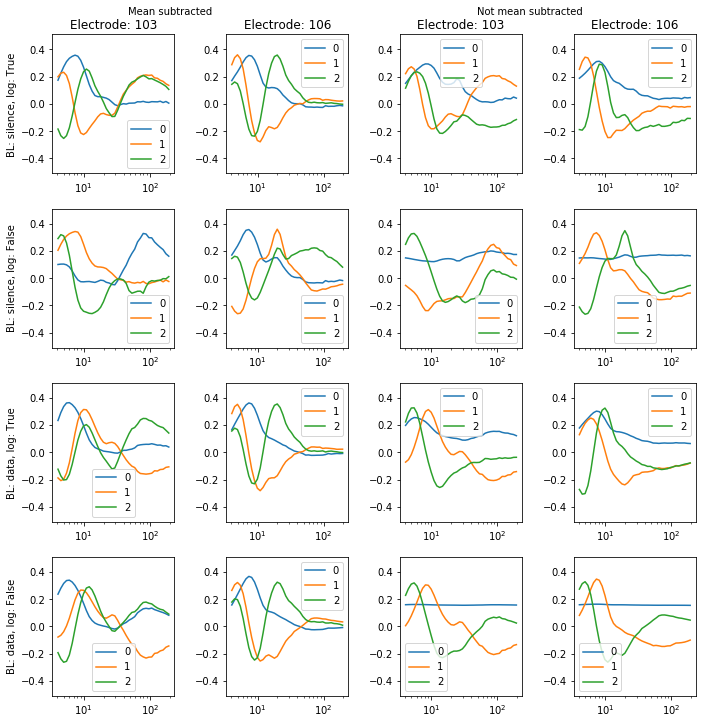

In [60]:
f, axes = plt.subplots(4, 4, figsize=(10, 10))
row = 0
bl_names = ['BL: silence', 'BL: data']
for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    for kk, log in enumerate([True, False]):
        row_ax = axes[row]
        for jj, center_pca in enumerate([True, False]):
            if row == 0:
                title=True
            else:
                title=False
            if jj == 0:
                ylabel = '{}, log: {}'.format(bl_names[ii], log)
            else:
                ylabel = None
            these_pcs = pcs[ii, jj, kk]
            axs = row_ax[jj * 2:jj * 2 +2]
            plot_103_106(these_pcs, (f, (axs)), title=title, ylabel=ylabel)
        row += 1
f.text(.25, .99, 'Mean subtracted', ha='center')
f.text(.75, .99, 'Not mean subtracted', ha='center')
max_val = 1.05 * abs(pcs).max()
for ax in axes.ravel():
    ax.set_ylim(-max_val, max_val)
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_103_106.pdf'.format(subject)))

In [52]:
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor

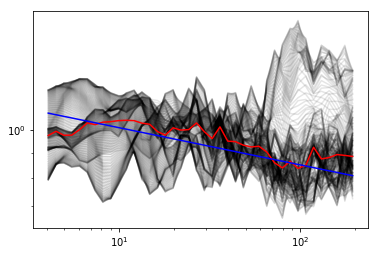

In [142]:
f, ax = plt.subplots(1)
cv = 3
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(103)].mean(axis=1)
ax.plot(x, y, c='k', alpha=.1)
ax.plot(x[:, 0], np.median(y, axis=1), c='red')
model = RANSACRegressor().fit(np.log(x.T).ravel()[:, np.newaxis], np.log(y.T).ravel())
yp = np.exp(model.estimator_.coef_ * np.log(x[:, 0]) + model.estimator_.intercept_)
ax.plot(x[:, 0], yp, c='blue')
ax.set_xscale('log')
ax.set_yscale('log')